# 전이 학습(transfer learning)

<img src = "./image/transfer_learning.png">

- 일반적으로 합성곱 신경망 기반의 딥러닝 모델을 제대로 훈련시키려면 많은 양의 데이터가 필요함
- 하지만 큰 데이터셋을 확보하고 훈련시키는 데에 많은 돈과 시간이 필요
- 이러한 문제를 해결하기 위해 전이 학습을 이용
- 전이 학습(transfer learning)
    - 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것
        - 이 때 아주 큰 데이터셋을 사용하여 훈련된 모델을 사전 학습 모델(사전 훈련된 모델) 이라고 함
    - 전이 학습을 이용하면 비교적 적은 수의 데이터를 가지고도 원하는 과제를 해결할 수 있음

## 특성 추출 기법(feature extractor)

<img src = "./image/feature_extractor.jpg">

- 사전 학습 모델을 가져온 후 완전연결층 부분만 새로 만듦
- 학습할 때는 완전연결층만 학습하고 나머지 계층은 학습되지 않도록 함
    - 데이터 분류기(완전연결층) : 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분
    
- 자주 사용되는 이미지 분류 사전학습 모델
    - Xception
    - Inception V3
    - ResVet50
    - VGG16
    - VGG19
    - MobileNet

In [1]:
import os
import time
import copy
import glob
import shutil
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
data_path = "./data/catanddog/train"

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [4]:
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    num_workers = 8,   # 병렬처리
    shuffle = True)

In [5]:
# 총 데이터 길이 개수
print(len(train_dataset))

385


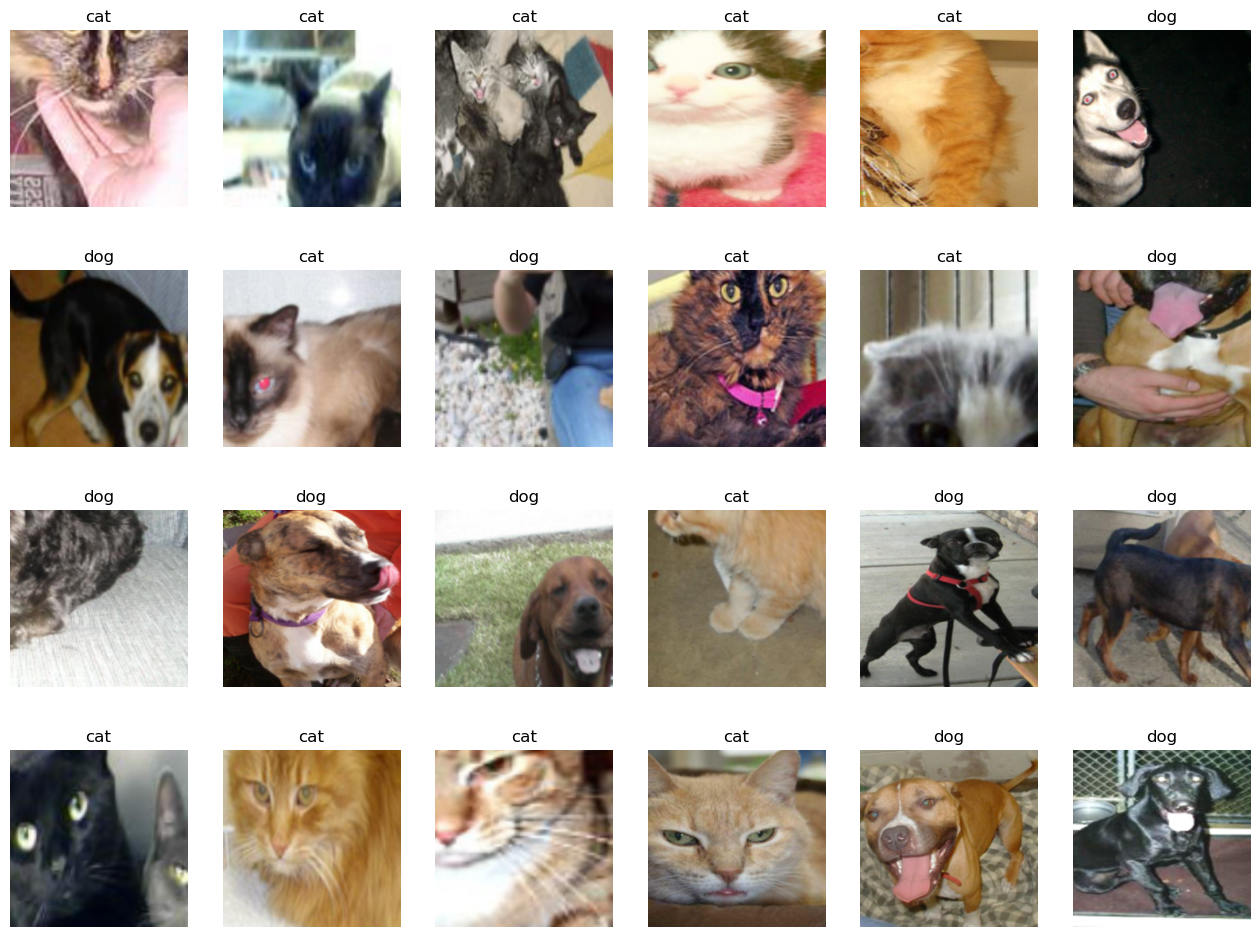

In [6]:
# 학습에 사용될 이미지 출력
samples, labels = next(iter(train_loader))   # train_loader 에서 데이터를 하나씩 꺼내오기
classes = {0 : "cat", 1 : "dog"}

fig = plt.figure(figsize = (16, 24))

for i in range(24):
    a = fig.add_subplot(4, 6, i + 1)
    a.set_title(classes[labels[i].item()])
    a.axis("off")
    a.imshow(np.transpose(samples[i].numpy(),(1, 2, 0)))
    #3, 224, 224 크기를 224, 224, 3 으로 변환
    
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)
             
            

In [8]:
samples.shape

torch.Size([32, 3, 224, 224])

In [10]:
np.transpose(samples[0].numpy(),(1, 2, 0)).shape

(224, 224, 3)

# 사전학습 모델 준비

In [13]:
# weights = "IMAGENET1K_V1" : IMAGENET1K_V1 데이터로 사전 학습된 가중치를 사용하겠다
resnet18 = models.resnet18(weights = "IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ITSC/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:03<00:00, 14.5MB/s]


## ResNet18

- 50개의 계층으로 구성된 합성곱 신경망
- ImageNet 데이터베이스의 100만개가 넘는 영상을 이용하여 훈련된 신경망
- 입력 제약이 매우 크고 충분한 메모리(RAM)가 없으면 학습 속도가 느려지는 단점이 있음

In [21]:
def set_parameter_requires_grad(model, feature_extracting = True):
    '''
    ResNet18 이 파라미터 학습을 하지 않도록 고정
    '''
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False  
            # 역전파 중 파라미터들에 대한 변화를 계산할 필요 없음

In [22]:
set_parameter_requires_grad(resnet18)

## 완전 연결층 추가

In [24]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
resnet18.fc = nn.Linear(512, 2) # 클래스가 2개

In [25]:
# 모델 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0118, -0.0076,  0.0149,  ..., -0.0256, -0.0412, -0.0160],
        [-0.0262, -0.0148,  0.0114,  ..., -0.0047, -0.0090, -0.0303]])
fc.bias tensor([0.0292, 0.0164])


# 모델 학습

In [41]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train = True):
    '''
    파라미터 : (모델, 학습데이터, 손실함수, 옵티마이저, 장치)
    '''
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch} / {num_epochs - 1}")
        print("-" * 10)
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        
        print(f"Loss : {epoch_loss:.4f} ACC : {epoch_acc:.4f}")
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join("./data/catanddog/", f"{epoch}.pth"))
        print()
        
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Acc: {best_acc:.4f}")
    return acc_history, loss_history

- 무거운 데이터일수록 에포크 많이 안 돌림

In [42]:
params_to_update = []

# 어떤 파라미터들이 옵티마이저로 전달되는지 설정
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)

fc.weight
fc.bias


In [43]:
optimizer = optim.Adam(params_to_update)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

In [45]:
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer,
                                             device)

Epoch 0 / 12
----------
Loss : 0.2811 ACC : 0.9143

Epoch 1 / 12
----------
Loss : 0.2865 ACC : 0.8805

Epoch 2 / 12
----------
Loss : 0.2659 ACC : 0.8883

Epoch 3 / 12
----------
Loss : 0.2846 ACC : 0.8779

Epoch 4 / 12
----------
Loss : 0.1887 ACC : 0.9403

Epoch 5 / 12
----------
Loss : 0.2559 ACC : 0.8857

Epoch 6 / 12
----------
Loss : 0.2326 ACC : 0.8987

Epoch 7 / 12
----------
Loss : 0.2533 ACC : 0.9039

Epoch 8 / 12
----------
Loss : 0.1806 ACC : 0.9429

Epoch 9 / 12
----------
Loss : 0.2059 ACC : 0.9065

Epoch 10 / 12
----------
Loss : 0.1902 ACC : 0.9325

Epoch 11 / 12
----------
Loss : 0.1717 ACC : 0.9377

Epoch 12 / 12
----------
Loss : 0.1682 ACC : 0.9377

Training complete in 3m 15s
Best Acc: 0.9429


# 테스트 데이터 평가

In [46]:
test_path = "./data/catanddog/test"

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = True)

In [47]:
# 총 데이터 수 
print(len(test_dataset))

98


In [54]:
# 평가
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0 
    
    saved_models = glob.glob('./data/catanddog/' + '*.pth')
    # 경로에서 pth 확장자를 갖는 파일을 가져오기
    saved_models.sort()
    print('saved_model', saved_models)
    
    # 1에포크 훈련하고 저장하고 2에포크돌리고 저장
    # 에포크마다 저장을 했음 
    # 그모델들을 하나하나 읽어서 어떤 모델이 베스트인지 테스트
    for model_path in saved_models:
        print('Loading model', model_path)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad(): # 훈련을 하지 않으므로 (gradient)자동 미분 계산 필요 없음 
                outputs = model(inputs) # 결과물이 나옴
                
            # 그 결과물로 예측값 뽑아내기
            _, preds = torch.max(outputs.data, 1) # 주어진 텐서 배열의 최댓값의 index를 반환
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0 # 0.5가 안되면 0으로 변환
            running_corrects += preds.cpu().eq(labels.cpu()).int().sum() # int로변환후 sum # 맞힌 것의 갯수
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f'Acc: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item())
        print()
        
    time_elapsed = time.time() - since
    print(f'Validation complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Acc: {best_acc:.4f}')
    
    return acc_history

- with : 텍스트 열고 닫기 할때 자동으로 닫아줄때 사용

In [55]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./data/catanddog\\0.pth', './data/catanddog\\1.pth', './data/catanddog\\10.pth', './data/catanddog\\11.pth', './data/catanddog\\12.pth', './data/catanddog\\2.pth', './data/catanddog\\3.pth', './data/catanddog\\4.pth', './data/catanddog\\5.pth', './data/catanddog\\6.pth', './data/catanddog\\7.pth', './data/catanddog\\8.pth', './data/catanddog\\9.pth']
Loading model ./data/catanddog\0.pth
Acc: 0.9490

Loading model ./data/catanddog\1.pth
Acc: 0.9388

Loading model ./data/catanddog\10.pth
Acc: 0.9592

Loading model ./data/catanddog\11.pth
Acc: 0.9388

Loading model ./data/catanddog\12.pth
Acc: 0.9490

Loading model ./data/catanddog\2.pth
Acc: 0.9592

Loading model ./data/catanddog\3.pth
Acc: 0.9490

Loading model ./data/catanddog\4.pth
Acc: 0.9592

Loading model ./data/catanddog\5.pth
Acc: 0.9388

Loading model ./data/catanddog\6.pth
Acc: 0.9388

Loading model ./data/catanddog\7.pth
Acc: 0.9694

Loading model ./data/catanddog\8.pth
Acc: 0.9490

Loading model ./data/catanddog

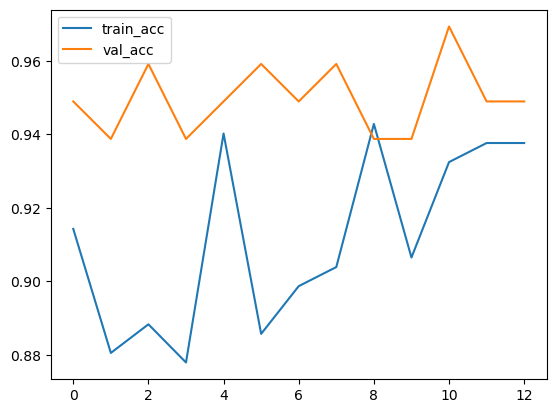

In [56]:
plt.plot(train_acc_hist, label = "train_acc")
plt.plot(val_acc_hist, label = "val_acc")
plt.legend()
plt.show()

# 예측 이미지 출력

In [58]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    # 기존 텐서의 내용을 복사한 텐서를 생성
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1) # 값을 특정 범위로 제한
    return image

- 텐서 복사 명령어 비교
    - tensor.clone()
        - 메모리 : 새롭게 할당
        - 계산 그래프에 계속 상주(기울기에 영향을 줌)
    
    - tensor.detach()
        - 메모리 : 공유해서 사용
        - 계산 그래프에 계속 상주하지 않음(기울기에 영향을 안줌)
    
    - tensor.clone().detach()
        - 메모리 : 새롭게 할당
        - 계산 그래프에 상주하지 않음
    

In [60]:
classes = {0 : "cat", 1 : "dog"}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = resnet18(images.to(device)) # 순전파 시켜서 나온 결과물(outputs)
_, preds = torch.max(output, 1)

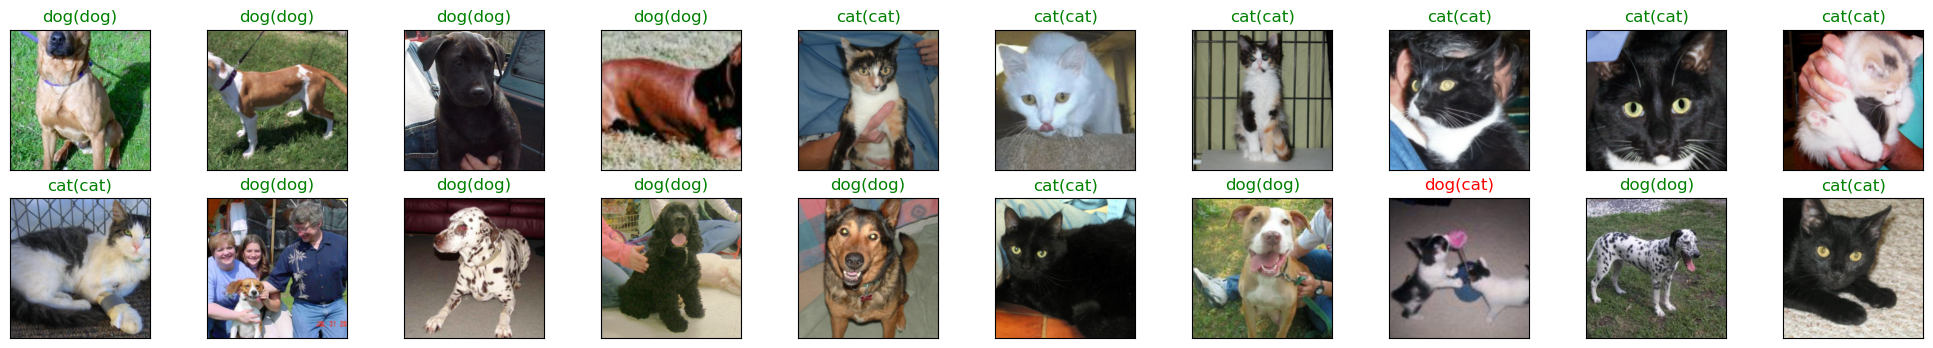

<Figure size 640x480 with 0 Axes>

In [62]:
fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    # 2행 10열로 subplot 만듦
    # 행, 열, 인덱스, 축(삭제)
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title(f"{str(classes[preds[idx].item()])}({str(classes[labels[idx].item()])})",
                color = ("green" if preds[idx] == labels[idx] else "red"))

plt.show()
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)